In [1]:
from browser_history.browsers import Firefox
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tldextract

In [2]:
f = Firefox()
outputs = f.fetch_history()

# his is a list of (datetime.datetime, url) tuples
his = outputs.histories

In [3]:
sep = '\t'
with open('history.txt', 'w') as file:
    file.write(f'timestamp{sep}url\n')
    for line in his:
        file.write(line[0].strftime("%m/%d/%Y %H:%M:%S") + sep + line[1] + '\n')

In [4]:
df = (
    pd
    .read_csv('history.txt', sep = sep)
    .assign(timestamp = lambda df: df.loc[:, 'timestamp'].apply(lambda t: pd.to_datetime(t, format="%m/%d/%Y %H:%M:%S")),
            date = lambda df: df.loc[:, 'timestamp'].apply(lambda t: t.strftime('%Y-%m-%d')),
            month = lambda df: df.loc[:, 'timestamp'].apply(lambda t: t.strftime('%Y-%m')),
            time = lambda df: df.loc[:, 'timestamp'].apply(lambda t: t.strftime('%H:%M')),
            time_continuous = lambda df: df.loc[:, 'time'].apply(lambda t: int(t[:2]) + int(t[3:])/60),
            domain = lambda df: df.loc[:, 'url'].apply(lambda url: tldextract.extract(url).domain),
            subdomain = lambda df: df.loc[:, 'url'].apply(lambda url: tldextract.extract(url).subdomain if tldextract.extract(url).subdomain != '' else 'No Subdomain')
           )
    .replace('www', 'No Subdomain')
)

In [ ]:
plt.axhline(y = 0, color = 'k', linestyle = '-')

(
    df
    .loc[:, 'time_continuous']
    .plot
    .density(
        bw_method = 0.1,
        ind = np.arange(0, 24, 0.005), 
        c = 'b'
    )
)

plt.title('Time at which Pages are Visited')
plt.xlabel('Hour of the Day')

plt.xlim(0, 24)
plt.show()

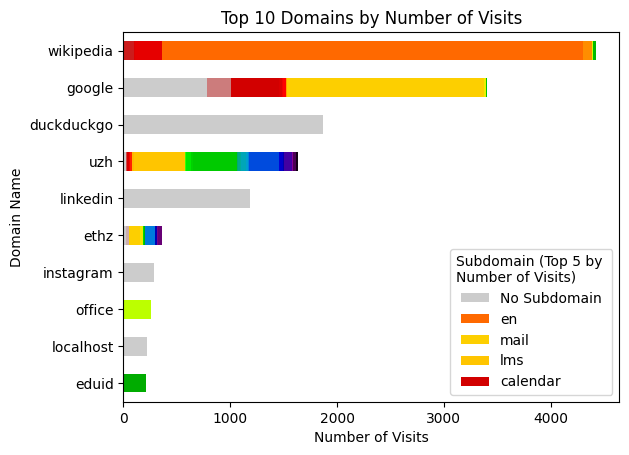

In [6]:
num_doms = 10
num_subdoms = 5
top_domains = df.groupby(by = 'domain').size().sort_values(ascending = False).head(num_doms).index
top_subdomains = df.loc[df.loc[:, 'domain'].isin(top_domains)].groupby(by = 'subdomain').size().sort_values(ascending = False).head(num_subdoms).index
colors = plt.cm.nipy_spectral_r(np.linspace(0, 1, len(df.loc[df.loc[:, 'domain'].isin(top_domains), 'subdomain'].unique())))
ax = (
    df
    .loc[df.loc[:, 'domain'].isin(top_domains)]
    .groupby(by = ['domain', 'subdomain'])
    .size()
    .unstack()
    .assign(total_views = lambda df: df.sum(axis = 1))
    .sort_values(by = 'total_views')
    .drop('total_views', axis = 1)
    .plot
    .barh(stacked = True, color = colors)
)

h, l = ax.get_legend_handles_labels()
artists = [h[i] for i in [l.index(label) for label in top_subdomains]]
plt.legend(artists, top_subdomains, title = f'Subdomain (Top {num_subdoms} by \nNumber of Visits)') 
plt.title(f'Top {num_doms} Domains by Number of Visits')

plt.xlabel('Number of Visits')
plt.ylabel('Domain Name')
plt.savefig('topdomains.png', bbox_inches ='tight')

plt.show()